# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Загрузка и подключение библиотек

In [3]:
!pip install scikit_learn==1.5.0 -q
!pip install phik -q

In [8]:
import pandas as pd
import phik
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка датафреймов

In [9]:
try:
    geo_data_0=pd.read_csv('/datasets/geo_data_0.csv')
except FileNotFoundError:
    geo_data_0=pd.read_csv('./geo_data_0.csv')

In [10]:
try:
    geo_data_1=pd.read_csv('/datasets/geo_data_1.csv')
except FileNotFoundError:
    geo_data_1=pd.read_csv('./geo_data_1.csv')

In [11]:
try:
    geo_data_2=pd.read_csv('/datasets/geo_data_2.csv')
except FileNotFoundError:
    geo_data_2=pd.read_csv('./geo_data_2.csv')

### geo_data_0

Просмотр первичной информации

In [33]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Просмотр первых строк

In [34]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Вывод количеста дубликатов

In [35]:
geo_data_0.duplicated().sum()

0

### geo_data_1

Просмотр первичной информации

In [36]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Просмотр первых строк

In [37]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Вывод количеста дубликатов

In [38]:
geo_data_1.duplicated().sum()

0

### geo_data_2

Просмотр первичной информации

In [39]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Просмотр первых строк

In [40]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Вывод количеста дубликатов

In [41]:
geo_data_2.duplicated().sum()

0

<b>Промежуточный вывод:</b> 

Мы видим, что данные для работы хорошо организованы. В каждом наборе данных ровно 100 000 записей, и нигде нет пустых мест. Более того, мы не нашли повторяющихся записей, то есть дубликатов.

В датасетах присутствуют только числовые характеристики, и отсутствуют любые категориальные переменные.

### Матрицы корреляции

Напишем функцию для построения матриц корреляции и графиков heatmap

In [42]:
def matrix_corr(df):
    phik_matrix=df.drop('id', axis=1).phik_matrix(interval_cols=df.drop('id', axis=1).columns.tolist())
    print(phik_matrix)
    plt.figure(figsize=(10, 7))
    sns.heatmap(phik_matrix, annot=True)

Матрица корреляции для geo_data_0

               f0        f1        f2   product
f0       1.000000  0.762170  0.000000  0.215525
f1       0.762170  1.000000  0.000000  0.253544
f2       0.000000  0.000000  1.000000  0.475901
product  0.215525  0.253544  0.475901  1.000000


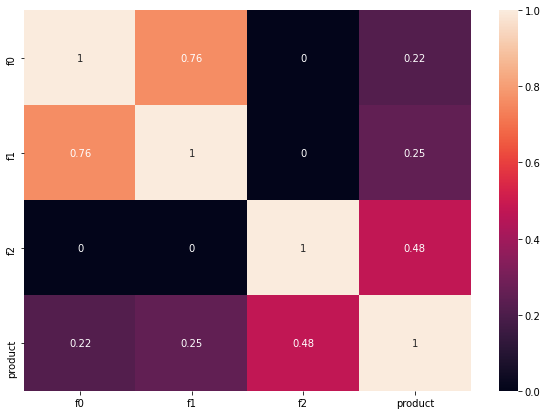

In [43]:
matrix_corr(geo_data_0)

Матрица корреляции для geo_data_1

               f0        f1        f2   product
f0       1.000000  0.196080  0.000000  0.628482
f1       0.196080  1.000000  0.000000  0.185965
f2       0.000000  0.000000  1.000000  0.978936
product  0.628482  0.185965  0.978936  1.000000


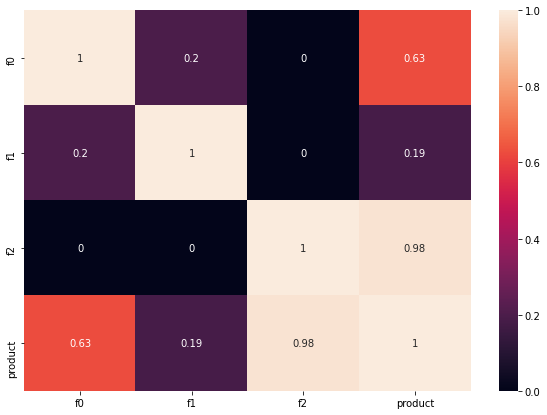

In [45]:
matrix_corr(geo_data_1)

Матрица корреляции для geo_data_2

               f0        f1        f2   product
f0       1.000000  0.000000  0.000000  0.201068
f1       0.000000  1.000000  0.000000  0.221022
f2       0.000000  0.000000  1.000000  0.443287
product  0.201068  0.221022  0.443287  1.000000


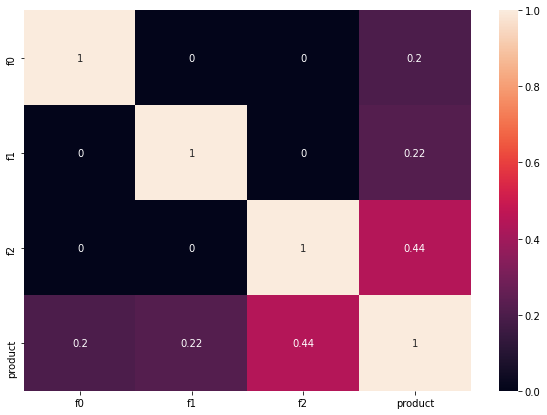

In [46]:
matrix_corr(geo_data_2)

<b>Промежуточный вывод:</b> 

- На первом графике сильная корреляция у f0 и f2 и средний уровень корреляции у product и f2
- На втором графике высокая корреляция у product И f0
- На третьем графике средний уровень корреляции у f2 и product

### Гистограммы

Напишем функцию для построения гистограмм

In [15]:
def plot_hist(df):
    phik_matrix=df.drop('id', axis=1).phik_matrix(interval_cols=df.drop('id', axis=1).columns.tolist())
    df.drop('id', axis=1).hist(figsize=(10, 7), bins=50)
    plt.tight_layout()
    plt.show()

Гистограмма для geo_data_0

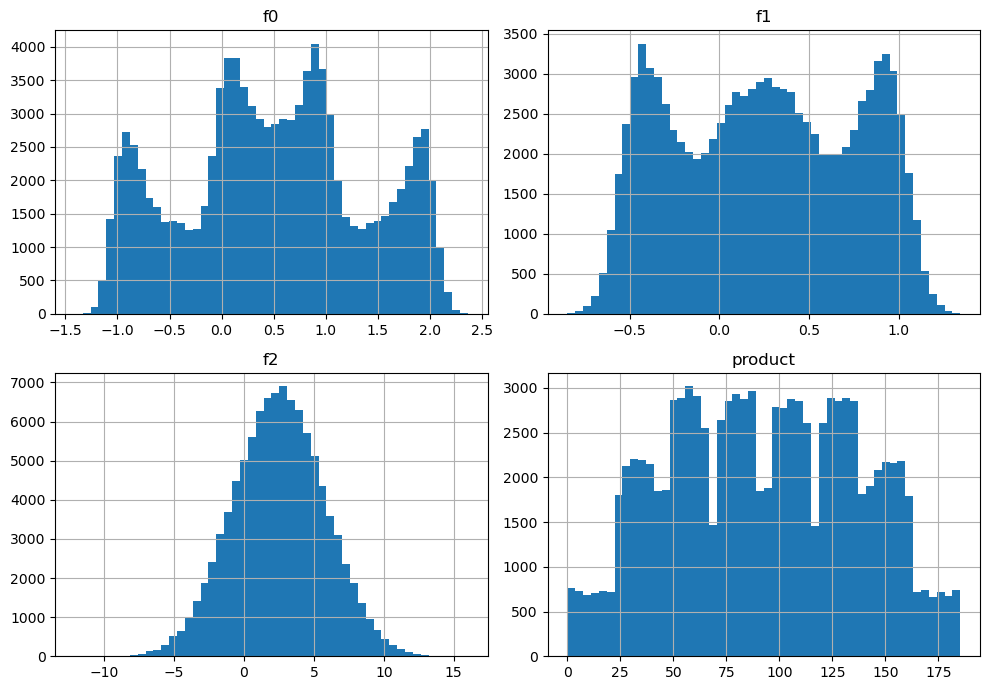

In [16]:
plot_hist(geo_data_0)

Гистограмма для geo_data_1

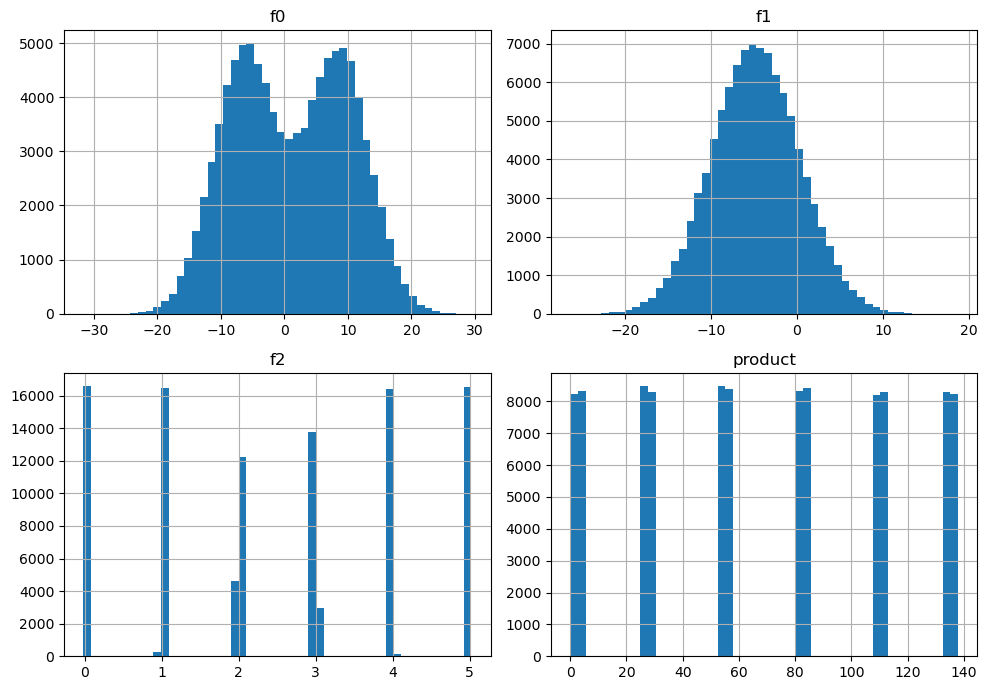

In [17]:
plot_hist(geo_data_1)

Гистограмма для geo_data_2

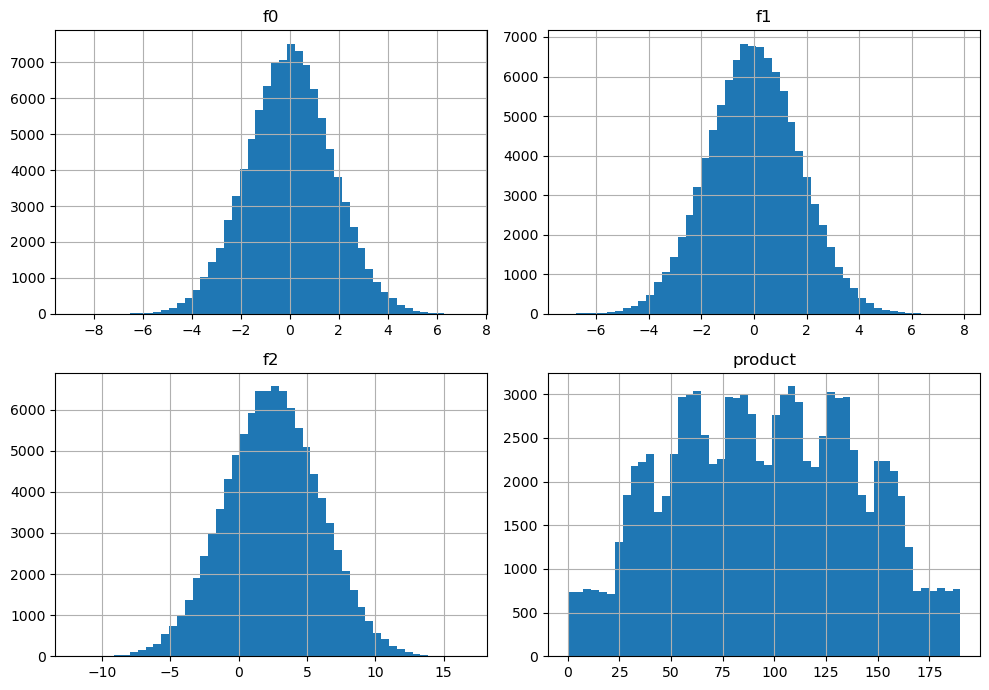

In [18]:
plot_hist(geo_data_2)

<b>Промежуточный вывод:</b>

Анализируя гистограммы, можно заметить, что распределение значений среди признаков значительно варьируется между различными датасетами. В частности, в датасете geo_data_1 заметны резкие отклонения в столбцах f2 и product, которые могут стать препятствием для эффективного обучения моделей.

<b>Вывод:</b> 
- Были установлены и импортированны нужные библиотеки
- Были загружены 3 датафрейма
- Был проведен первычный анализ данных

## Обучение и проверка модели

## Подготовка к расчёту прибыли

## Расчёт прибыли и рисков 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован